In [1]:
import mmcv
from mmcv import Config
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)

from tqdm import tqdm
import albumentations as A

from mmdet.models import build_detector
from mmdet.apis import single_gpu_test, init_detector, inference_detector
from mmcv.runner import load_checkpoint
import os
from mmcv.parallel import MMDataParallel
import pandas as pd
import pycocotools
from pycocotools.coco import COCO
import numpy as np

import matplotlib.pyplot as plt

In [2]:
classes = ("General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")

# config file 들고오기
cfg = Config.fromfile('/opt/ml/Git/p_stage_img_seg/work_dirs/swin-s_img-768_AdamW-20e_soft-nms2/swin-s_img-768_AdamW-20e_soft-nms2.py')

# dataset config 수정
# cfg.data.test.classes = classes
# cfg.data.test.img_prefix = root
# cfg.data.test.ann_file = root + 'test.json'
# cfg.data.test.pipeline[1]['img_scale'] = (512,512) # Resize
cfg.data.test.test_mode = True
cfg.data.samples_per_gpu = 2
cfg.data.workers_per_gpu = 2

cfg.seed = 123456
cfg.gpu_ids = [0]
cfg.work_dir = '/opt/ml/Git/p_stage_img_seg/work_dirs/swin-s_img-768_AdamW-20e_soft-nms2/'

# cfg.model.roi_head.bbox_head.num_classes = 10

# cfg.optimizer_config.grad_clip = dict(max_norm=35, norm_type=2)
cfg.model.train_cfg = None

In [3]:
# build dataset & dataloader
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
        dataset,
        samples_per_gpu=cfg.data.samples_per_gpu,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [4]:
# checkpoint path
checkpoint_path = os.path.join(cfg.work_dir, f'latest.pth')

model = build_detector(cfg.model, test_cfg=cfg.get('test_cfg')) # build detector
# checkpoint = load_checkpoint(model, checkpoint_path, map_location='cpu') # ckpt load
checkpoint = load_checkpoint(model, checkpoint_path) # ckpt load

model.CLASSES = dataset.CLASSES
model = MMDataParallel(model.cuda(), device_ids=[0])

/opt/ml/Git/mmdetection/mmdet/core/anchor/builder.py:17: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  '``build_anchor_generator`` would be deprecated soon, please use '


Use load_from_local loader


In [5]:
output = single_gpu_test(model, data_loader, show_score_thr=0.05) # output 계산

[                                                  ] 0/819, elapsed: 0s, ETA:

/opt/ml/Git/mmdetection/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/opt/ml/Git/mmdetection/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 819/819, 6.1 task/s, elapsed: 135s, ETA:     0s

## Load COCO json

In [ ]:
prediction_strings = []
file_names = []
coco = COCO(cfg.data.test.ann_file)
# coco = COCO('/opt/ml/segmentation/input/data/test.json')
image_path = '/opt/ml/segmentation/input/data/'
img_ids = coco.getImgIds()

dummy_image = np.zeros((512, 512))

In [7]:
def instanceMask2semtsegMaskV2(output, n_class: int=10, img_size: list=[512, 512], score_thrs: float=0.2):
    tmp_mask_arr = np.zeros((n_class+1, *img_size))
    for class_idx in range(n_class):
        _len = output[1][class_idx].__len__()
        if _len == 0:
            continue
        mask_arr = pycocotools.mask.decode(output[1][class_idx])
        for i in range(mask_arr.shape[-1]):
            cf_score = output[0][class_idx][i, -1]
            if cf_score >= score_thrs:
                maskBitmap = mask_arr[:, :, i]
                tmp_mask_arr[class_idx+1] += cf_score * maskBitmap
        
    return np.argmax(tmp_mask_arr, axis=0)

## Extract semantic mask and image

In [ ]:
from pathlib import Path
import cv2

In [ ]:
def merge_image(insert_image, insert_mask, class_id, base_image=None, base_mask=None):
    """
    Args:
        insert_image: 
        insert_mask:
        class_id:
        base_image:
        base_mask:
    """
    tmp_img = np.ones((512,512,3), dtype=np.uint8) * 255
    if type(base_image) is type(None):
        base_image = tmp_img.copy()
    tmp_img[:,:,0] = np.where(insert_mask == class_id, insert_image[:,:,0], base_image[:,:,0])  # R
    tmp_img[:,:,1] = np.where(insert_mask == class_id, insert_image[:,:,1], base_image[:,:,1])  # G
    tmp_img[:,:,2] = np.where(insert_mask == class_id, insert_image[:,:,2], base_image[:,:,2])  # B
    if type(base_mask) is type(None):
        base_mask = np.zeros((512,512), dtype=np.uint8)
    tmp_mask = np.where(insert_mask == class_id, insert_mask, base_mask)  # mask
    return tmp_img, tmp_mask

In [ ]:
seg_output = []

for i, out in tqdm(enumerate(output)):
    image_info = coco.loadImgs(coco.getImgIds(imgIds=img_ids[i]))[0]
    tmp_mask_arr = instanceMask2semtsegMaskV2(out, score_thrs=0.3)
    seg_output.append(tmp_mask_arr)

In [ ]:

classes = ("Background", "General trash", "Paper", "Paper pack", "Metal", "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")

# ------------------------------------------- #
target_category = 1
# ------------------------------------------- #

save_dir = f"/opt/ml/segmentation/extract_image/{target_category}"
Path(f"{save_dir}/image/").mkdir(exist_ok=True, parents=True)
Path(f"{save_dir}/mask/").mkdir(exist_ok=True, parents=True)

for i, seg_mask in tqdm(enumerate(seg_output)):
    if not np.isin(target_category, seg_mask):
        continue
    image_info = coco.loadImgs(coco.getImgIds(imgIds=img_ids[i]))[0]
    image = cv2.imread(image_path + image_info['file_name'])
    catImage, catSegMask = merge_image(image, seg_mask, target_category)
    _path = Path(image_info['file_name'])
    image_name = f"{save_dir}/image/{_path.parent}_{_path.stem}.png"
    mask_name = f"{save_dir}/mask/{_path.parent}_{_path.stem}.mask.png"
    cv2.imwrite(image_name, catImage)
    cv2.imwrite(mask_name, catSegMask)

## Inference

In [8]:
class_num = 10

for i, out in tqdm(enumerate(output)):
    image_info = coco.loadImgs(coco.getImgIds(imgIds=img_ids[i]))[0]
    tmp_mask_arr = instanceMask2semtsegMaskV2(out, score_thrs=0.5)
    resized_tmp_mask_arr = A.Resize(256, 256)(image=dummy_image, mask=tmp_mask_arr)['mask']
    resized_tmp_mask_arr = resized_tmp_mask_arr.flatten().tolist()
    prediction_strings.append(' '.join(str(e) for e in resized_tmp_mask_arr))
    # prediction_strings.append(' '.join(str(e) for e in instanceMask2semtsegMaskV2(out, score_thrs=0.5).tolist()))
    file_names.append(image_info['file_name'])

submission = pd.DataFrame()
submission['image_id'] = file_names
submission['PredictionString'] = prediction_strings
submission.to_csv('/opt/ml/Git/p_stage_img_seg/submission/swin-s_all_submission.V2.yb006.csv', index=None)
submission.head()

0it [00:00, ?it/s]

loading annotations into memory...
Done (t=0.14s)
creating index...
index created!


819it [00:52, 14.21it/s]


,image_id,PredictionString
0,batch_01_vt/0021.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1,batch_01_vt/0028.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
2,batch_01_vt/0031.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
3,batch_01_vt/0032.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
4,batch_01_vt/0076.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


In [138]:
def instanceMask2semtsegMask(output, n_class: int=10, img_size: list=[512, 512], score_thrs: float=0.2):
    dummy_image = np.zeros(img_size)
    tmp_mask_arr = np.zeros(img_size, dtype=np.uint8)
    for class_idx in range(n_class):
        _len = output[1][class_idx].__len__()
        if _len == 0:
            continue
        mask_arr = pycocotools.mask.decode(output[1][class_idx])
        for i in range(mask_arr.shape[-1]):
            cf_score = output[0][class_idx][i, -1]
            if cf_score >= score_thrs:
                maskBitmap = mask_arr[:, :, i]
                tmp_mask_arr = np.where(maskBitmap == 1, class_idx+1, tmp_mask_arr)
    resized_tmp_mask_arr = A.Resize(256, 256)(image=dummy_image, mask=tmp_mask_arr)['mask']
    return resized_tmp_mask_arr.flatten()

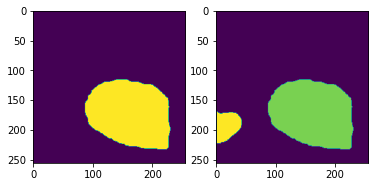

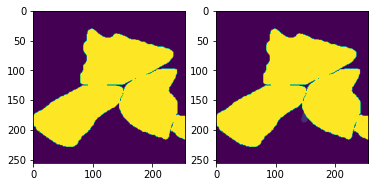

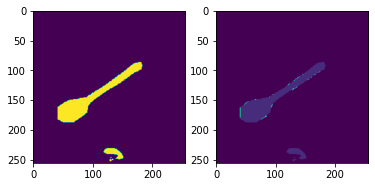

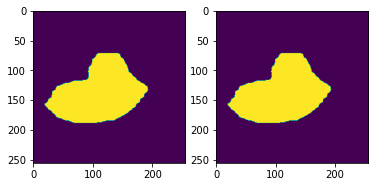

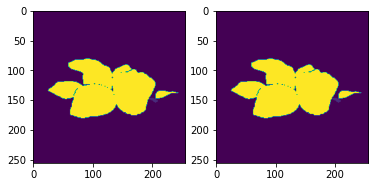

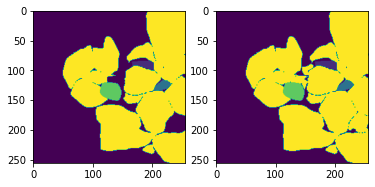

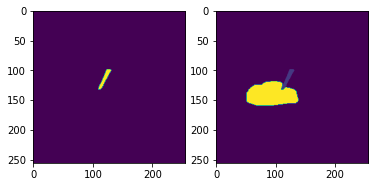

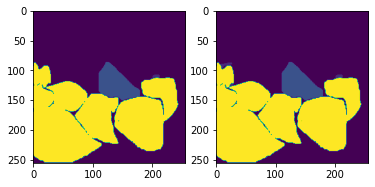

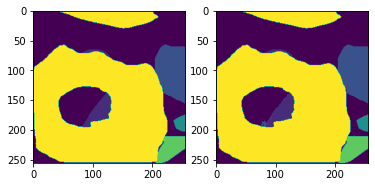

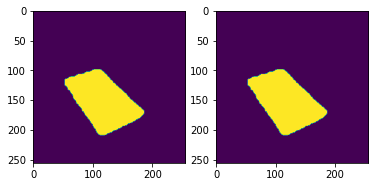

In [160]:
for i in range(10):
    fig, ax = plt.subplots(1, 2)
    # a1 = instanceMask2semtsegMask(output[i], score_thrs=0.2)
    a1 = instanceMask2semtsegMaskV2(output[i], score_thrs=0.5)
    a2 = instanceMask2semtsegMaskV2(output[i], score_thrs=0.3)
    ax[0].imshow(a1.reshape(256, 256))
    ax[1].imshow(a2.reshape(256, 256))
    plt.show()